c:\anaconda3\envs\ml-project-env-10\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


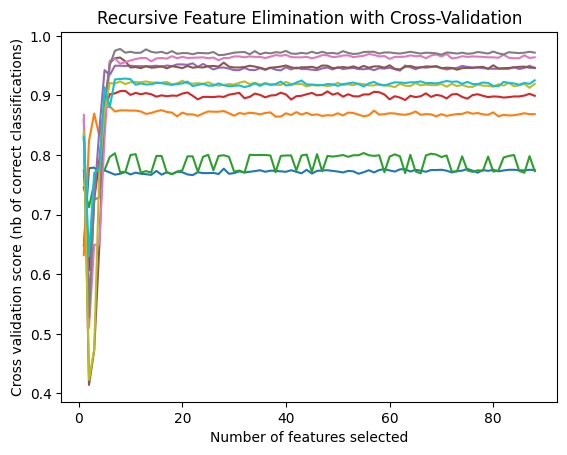

Selected features: Index(['model_year', 'cylinders_', 'fuelconsumption_city(l/100km)',
       'fuelconsumption_hwy(l/100km)', 'co2emissions_(g/km)',
       'number_of_gears', 'fuelconsumption_comb(mpg)'],
      dtype='object')


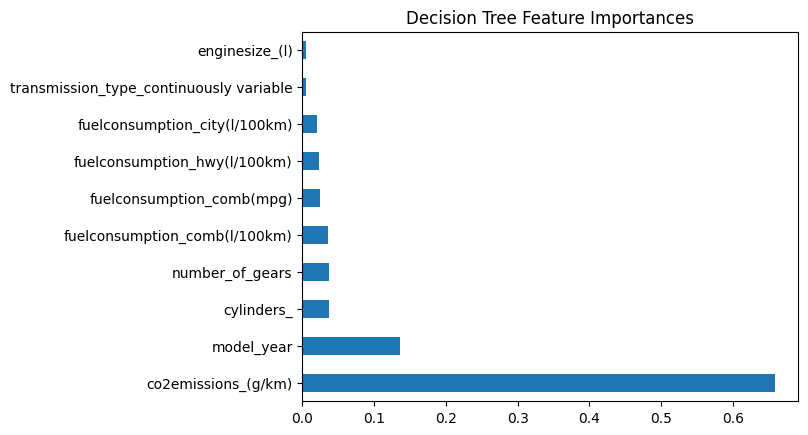

Top features: ['model_year', 'cylinders_', 'fuelconsumption_city(l/100km)', 'fuelconsumption_hwy(l/100km)', 'fuelconsumption_comb(l/100km)', 'co2emissions_(g/km)', 'number_of_gears', 'enginesize_(l)', 'fuelconsumption_comb(mpg)', 'transmission_type_continuously variable']
Epoch 1/50
674/674 [==============================] - 2s 2ms/step - loss: 0.8773 - val_loss: 0.6511
Epoch 2/50
674/674 [==============================] - 2s 2ms/step - loss: 0.6226 - val_loss: 0.6020
Epoch 3/50
674/674 [==============================] - 1s 2ms/step - loss: 0.5969 - val_loss: 0.5890
Epoch 4/50
674/674 [==============================] - 1s 2ms/step - loss: 0.5883 - val_loss: 0.5834
Epoch 5/50
674/674 [==============================] - 1s 2ms/step - loss: 0.5835 - val_loss: 0.5796
Epoch 6/50
674/674 [==============================] - 1s 2ms/step - loss: 0.5796 - val_loss: 0.5760
Epoch 7/50
674/674 [==============================] - 1s 2ms/step - loss: 0.5758 - val_loss: 0.5731
Epoch 8/50
674/674 [=======

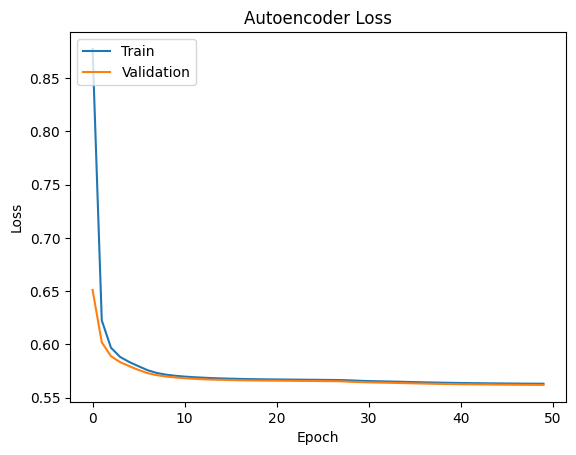

169/169 [==============================] - 0s 1ms/step


In [9]:
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
from pathlib import Path
from sklearn.cluster import KMeans


sys.path.append(os.path.abspath(os.path.join('..','./data/', './clean-data/')))
sys.path.append(os.path.abspath(os.path.join('..','./scripts/')))


# Load the dataset into a pandas DataFrame
df = pd.read_csv(Path("../data/predicted-data/","predicted_co2_rating.csv"))

# Select the columns with numerical and categorical data
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# One-hot encode the categorical columns
df_cat = pd.get_dummies(df[['vehicleclass_','make_','vehicle_type','transmission_type']])
df_num = df[num_cols]

# Combine the numerical and one-hot encoded categorical dataframes
df_processed = pd.concat([df_num, df_cat], axis=1)

# Perform recursive feature elimination to select the most important features
X = df_processed.drop(["predicted_co2_rating", "original_co2r", "id"], axis=1)
y = df_processed["predicted_co2_rating"]

dt = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=dt, cv=10)
rfecv.fit(X, y)

# Plot the number of features vs. cross-validation scores
plt.figure()
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Print the most important features
print("Selected features:", X.columns[rfecv.support_])

# Fit a decision tree and get feature importances
dt.fit(X, y)
feat_importances = pd.Series(dt.feature_importances_, index=X.columns)

# Plot the feature importances
plt.figure()
plt.title('Decision Tree Feature Importances')
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Select the top 5 most important features
threshold = feat_importances.nlargest(10).min()
top_features = feat_importances[feat_importances >= threshold].index.tolist()
print("Top features:", top_features)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[top_features])

# Split the data into training and validation sets
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 5

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
history = autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=50, batch_size=32)

# Visualize the loss over epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Get the encoded features
encoder = Model(inputs=input_layer, outputs=encoder)
encoded_features_train = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

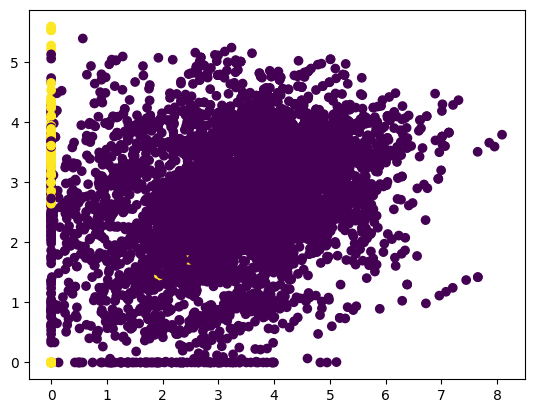

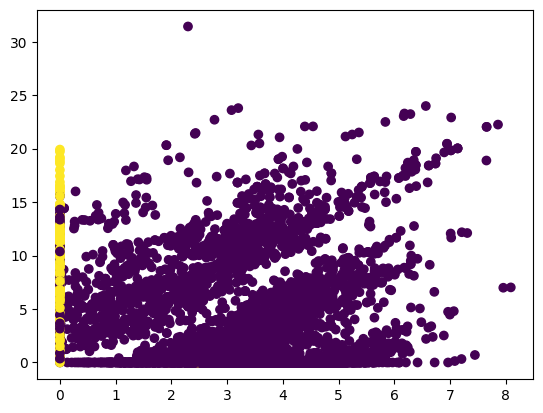

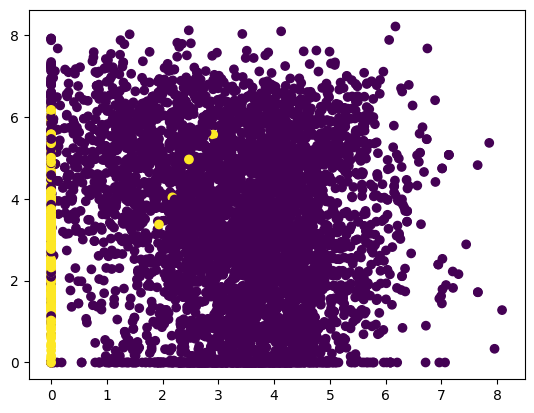

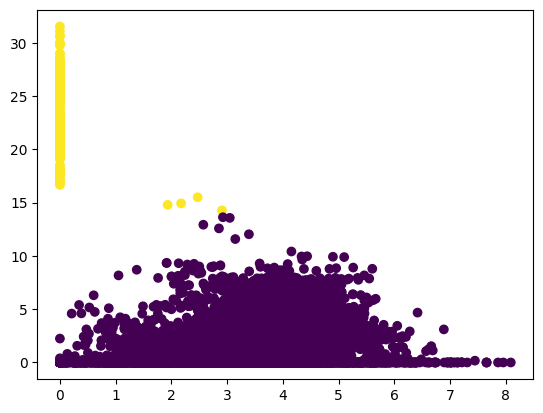

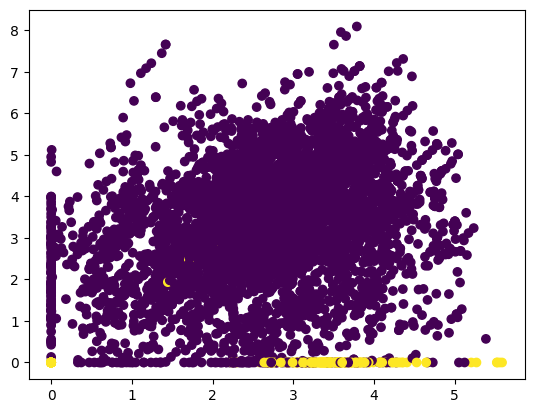

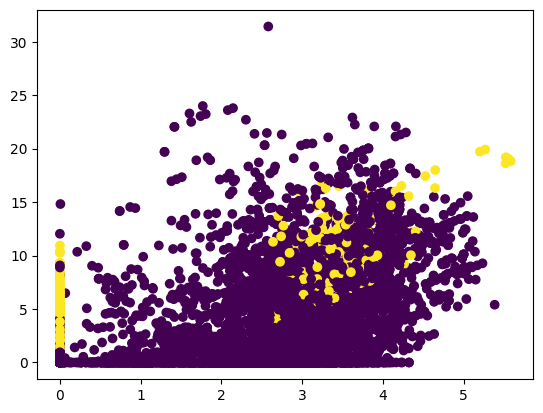

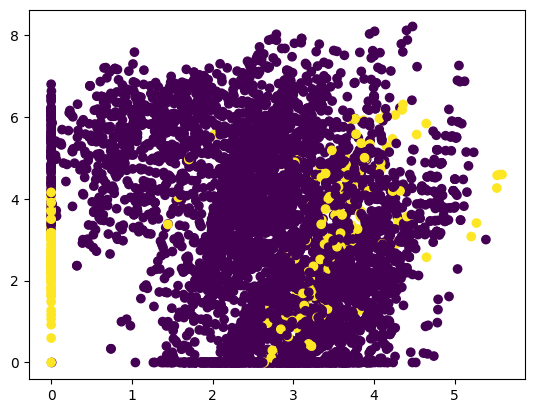

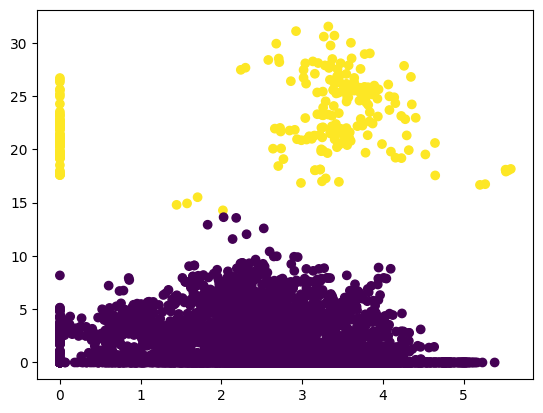

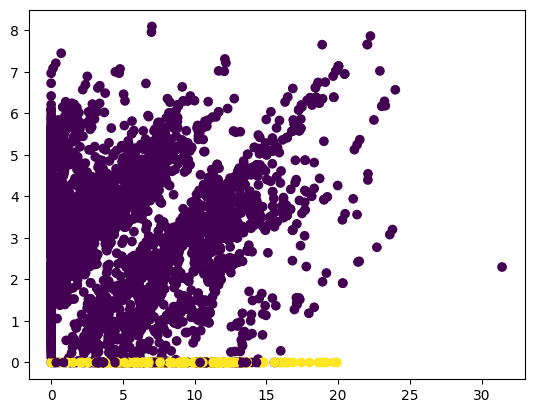

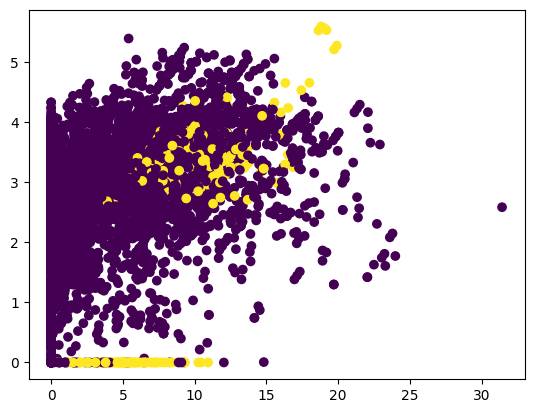

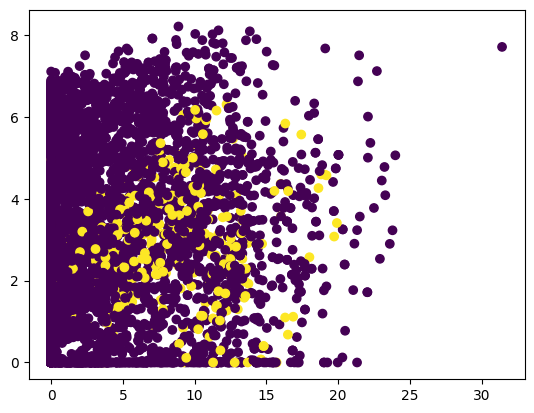

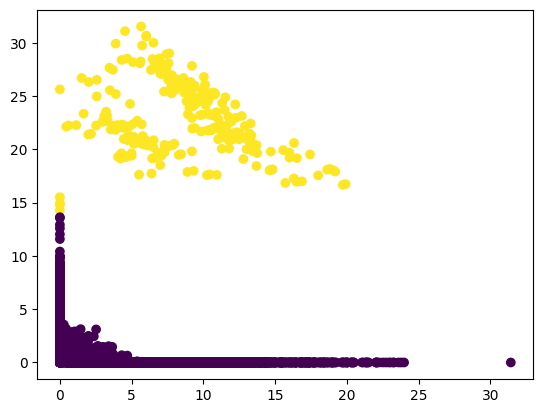

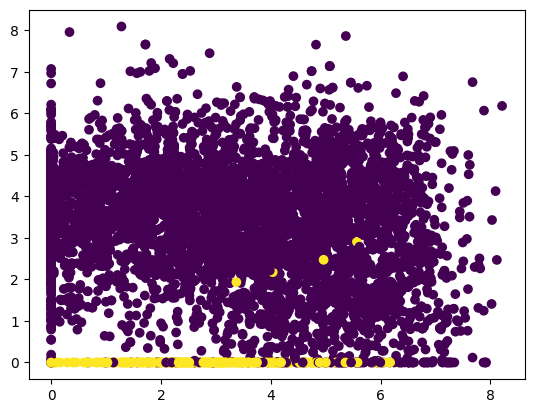

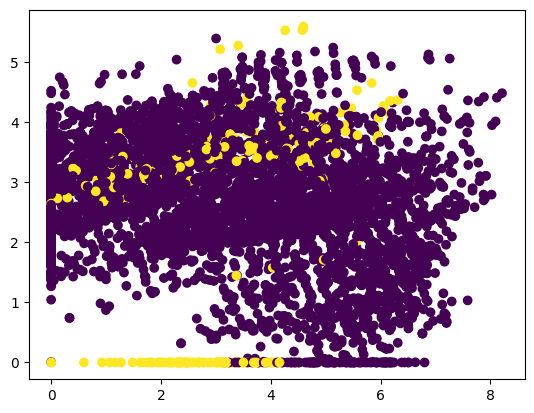

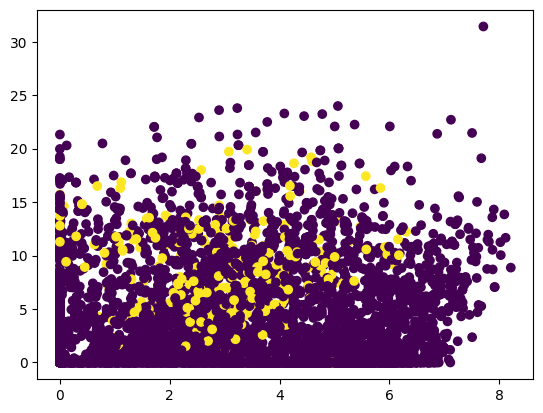

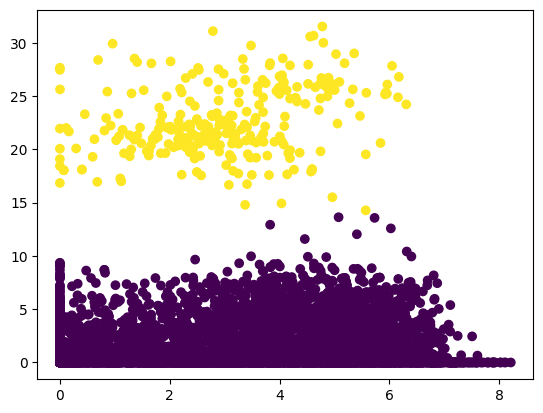

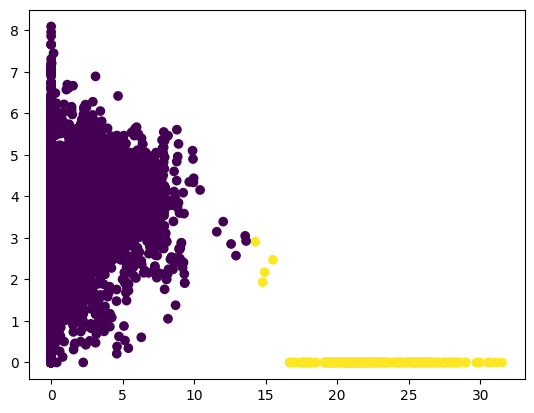

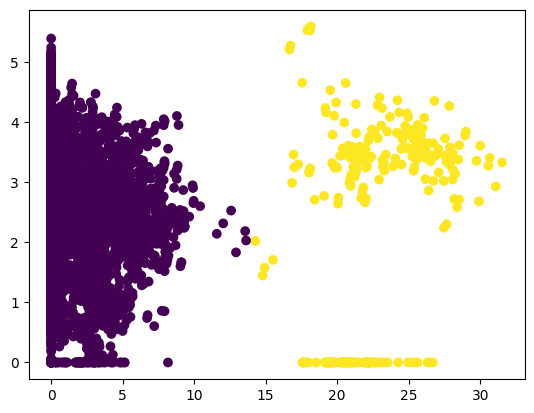

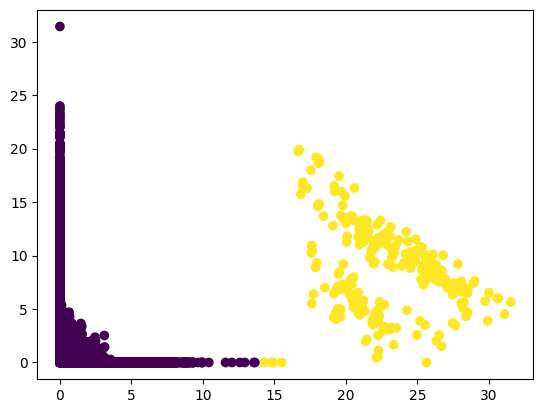

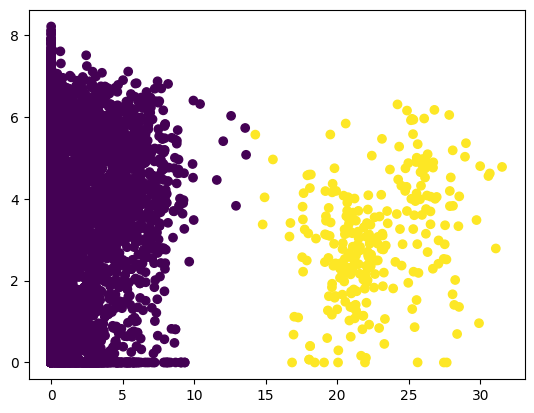

In [11]:
# Use KMeans clustering to cluster the encoded features
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(encoded_features_train)

# Visualize the clusters in the validation set
encoded_features_val_clusters = kmeans.predict(encoded_features_val)

for i in range(0,5):
    for j in range(0,5):
        if i != j:
            plt.scatter(encoded_features_val[:, i], encoded_features_val[:, j], c=encoded_features_val_clusters)
            plt.show()


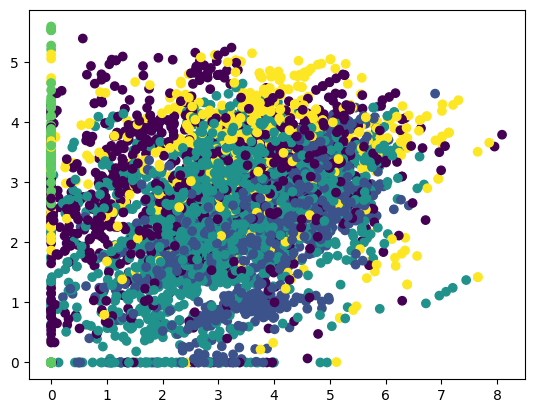

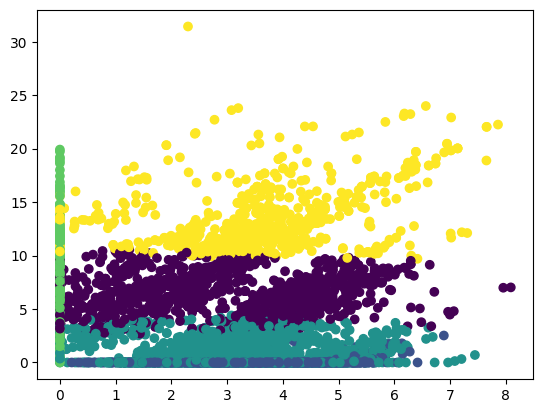

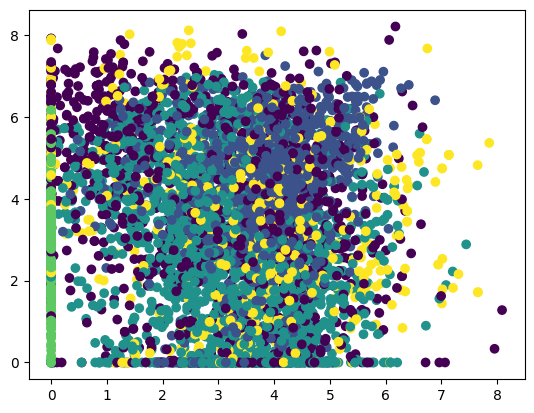

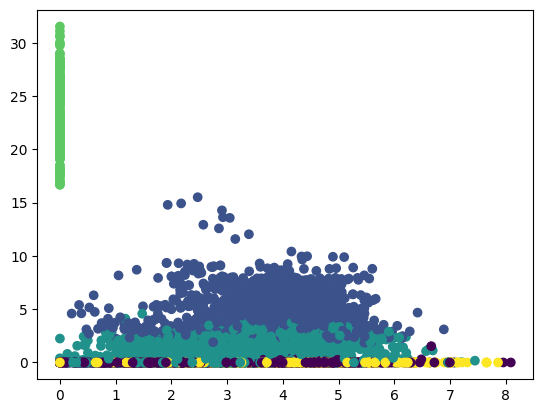

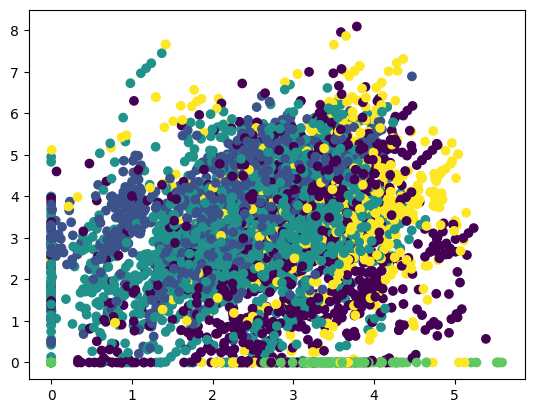

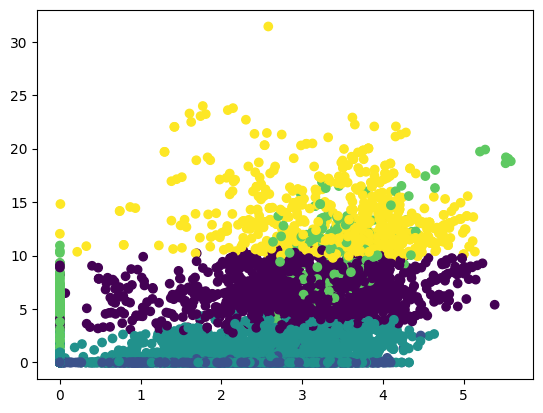

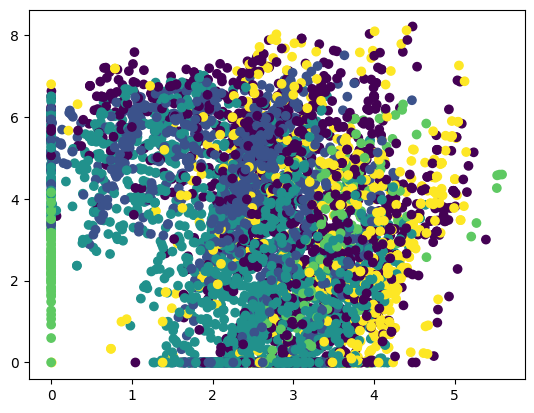

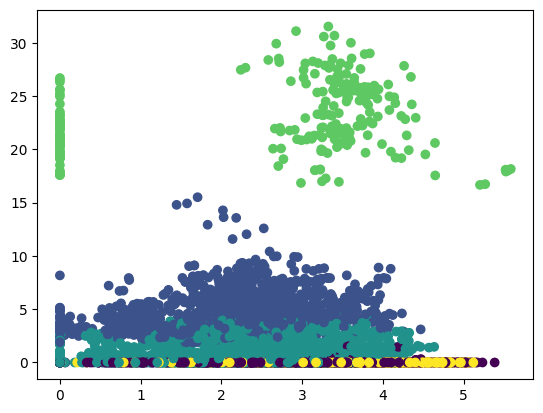

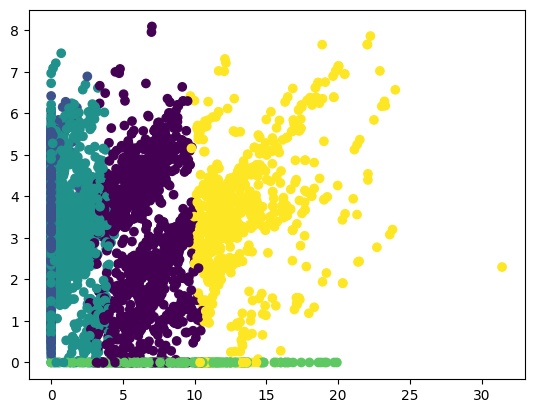

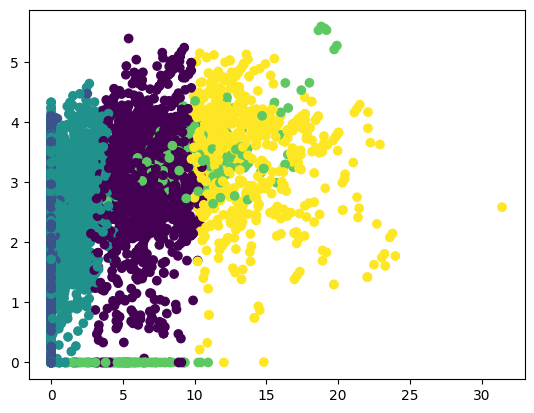

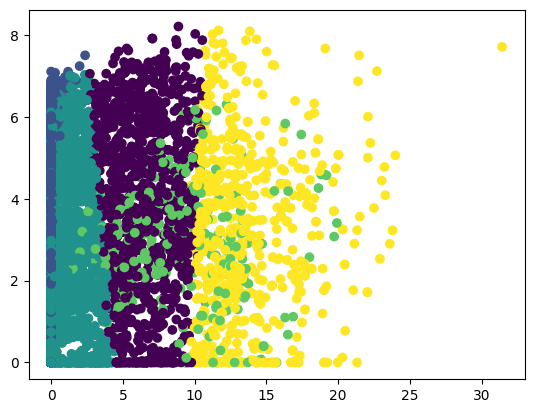

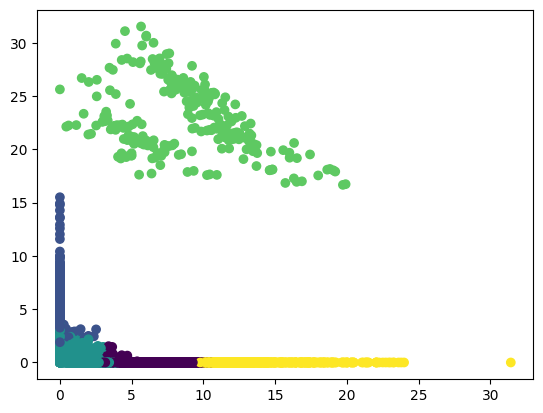

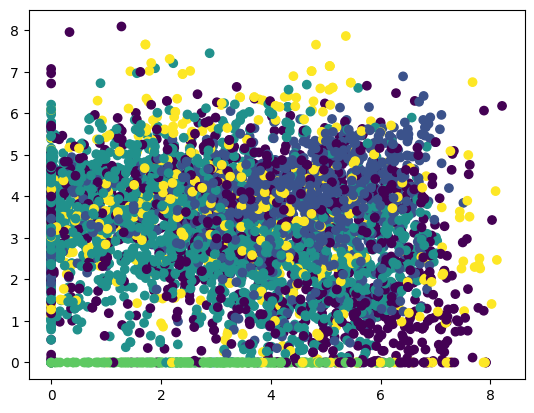

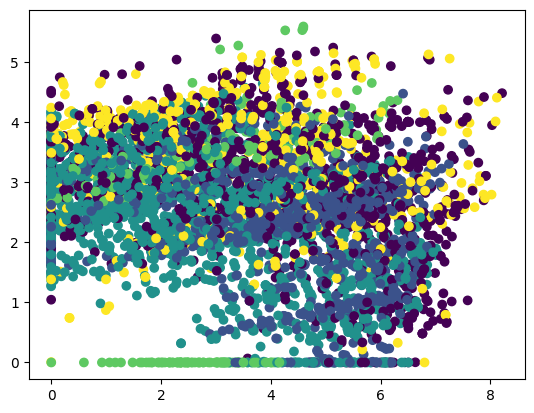

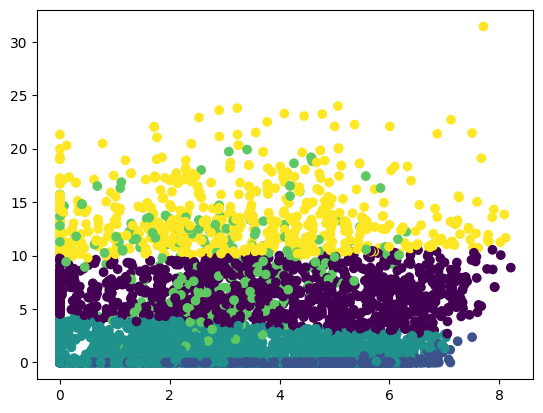

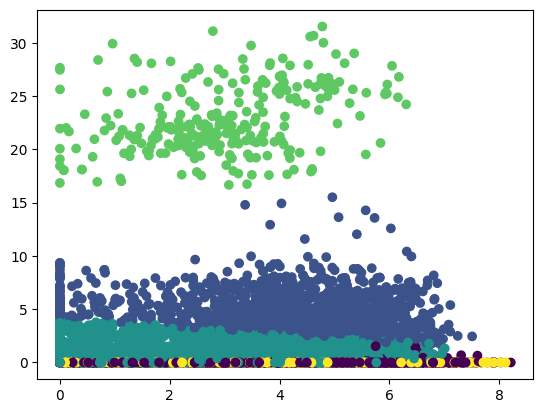

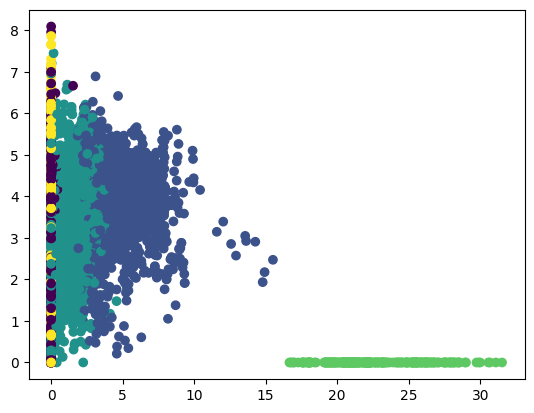

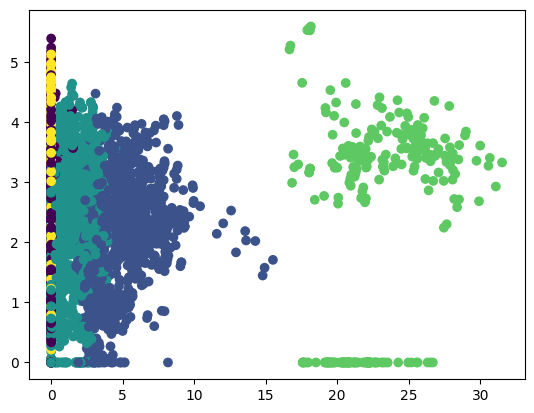

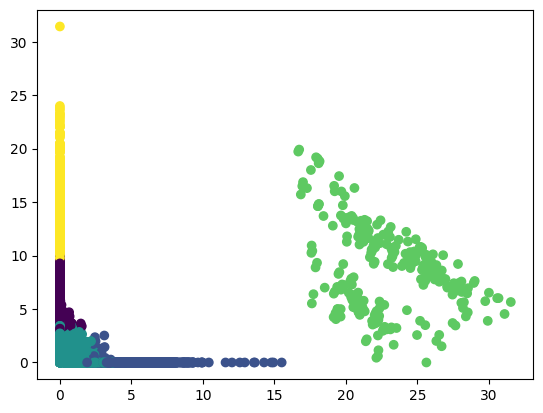

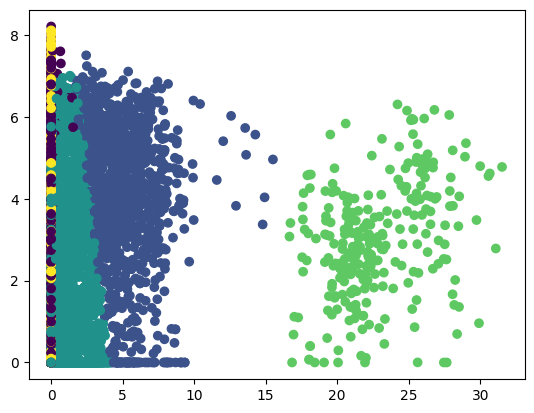

In [12]:
# Use KMeans clustering to cluster the encoded features
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(encoded_features_train)

# Visualize the clusters in the validation set
encoded_features_val_clusters = kmeans.predict(encoded_features_val)

for i in range(0,5):
    for j in range(0,5):
        if i != j:
            plt.scatter(encoded_features_val[:, i], encoded_features_val[:, j], c=encoded_features_val_clusters)
            plt.show()


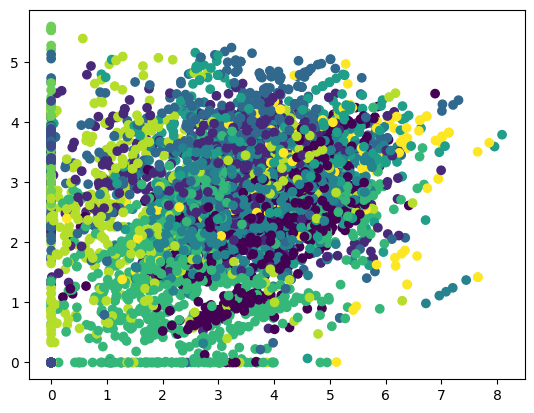

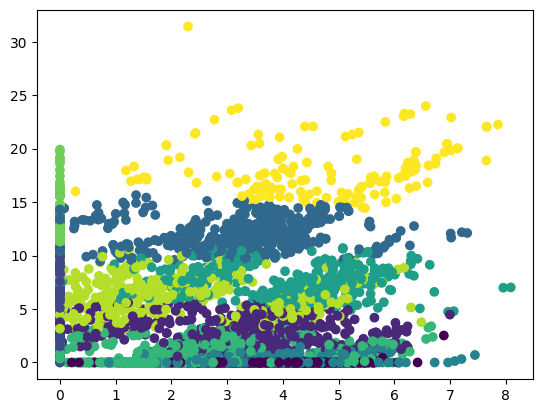

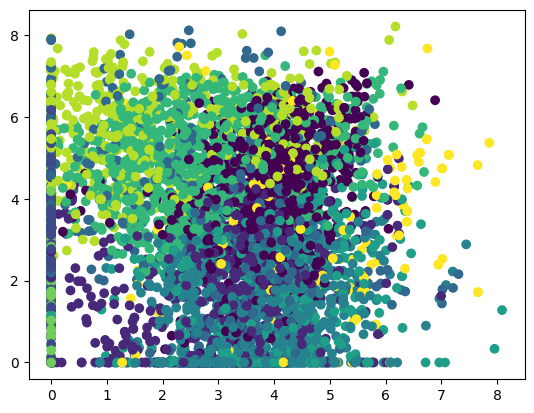

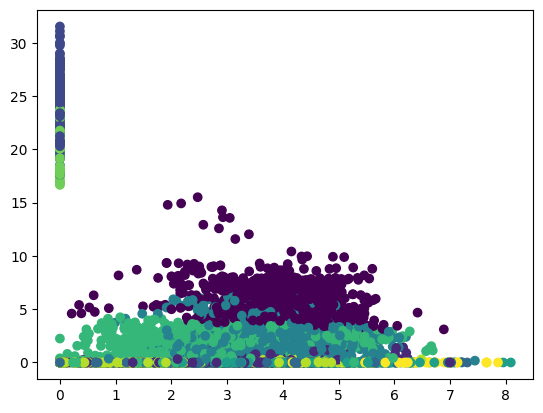

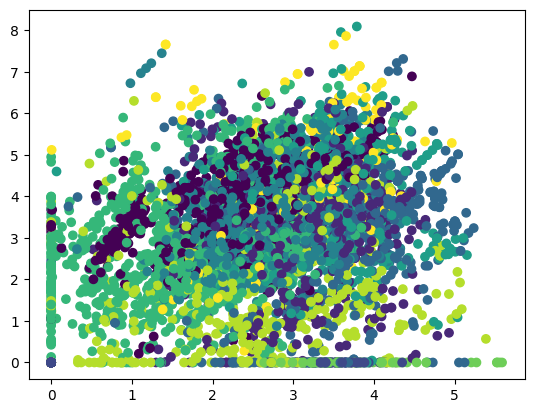

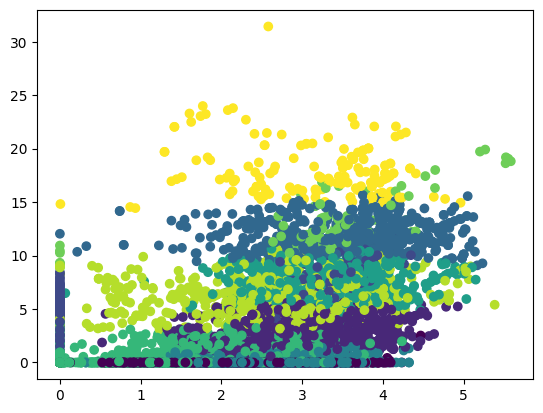

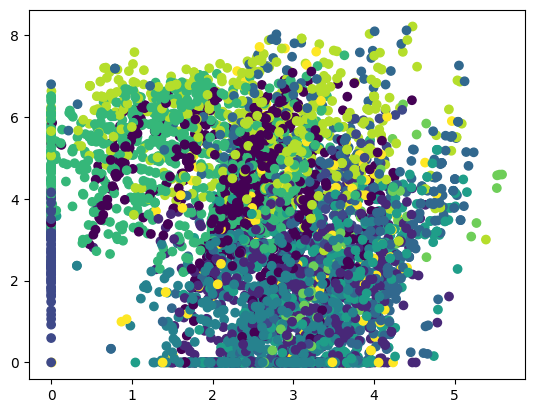

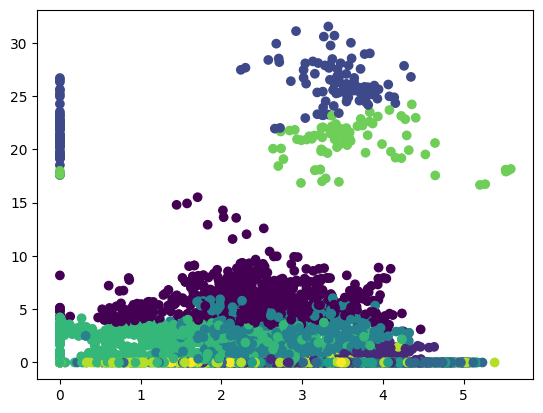

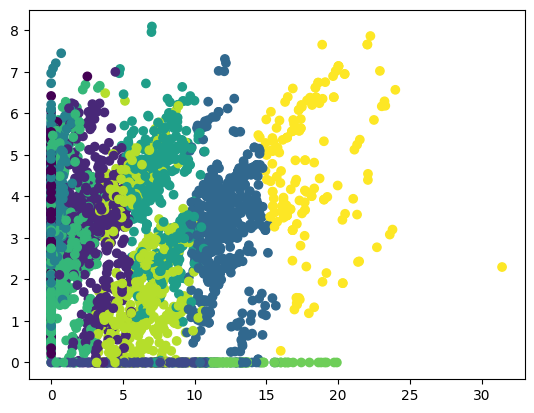

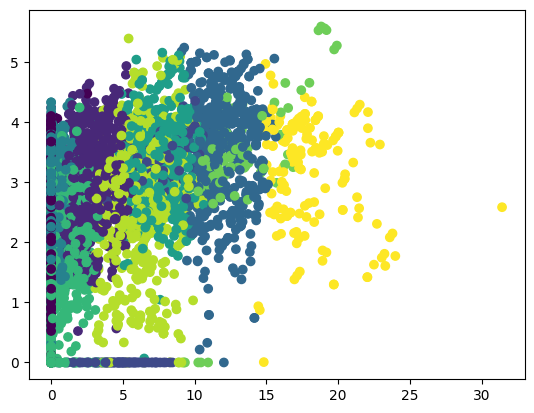

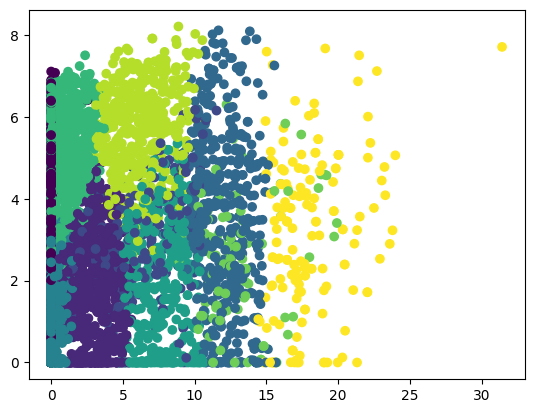

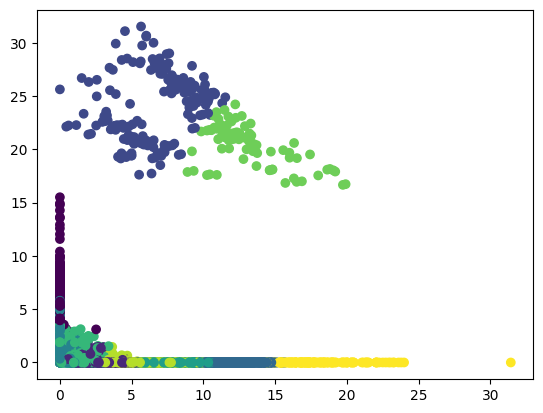

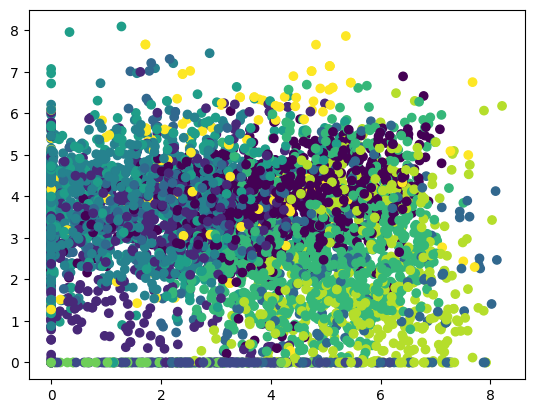

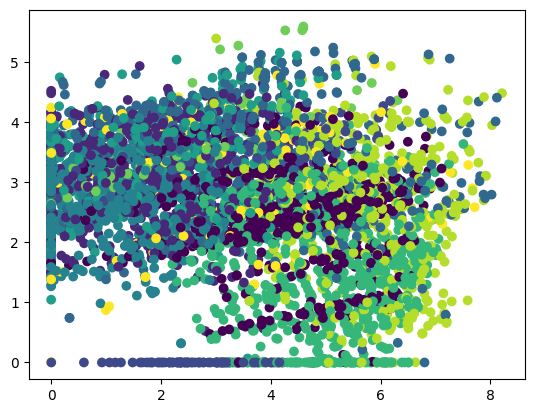

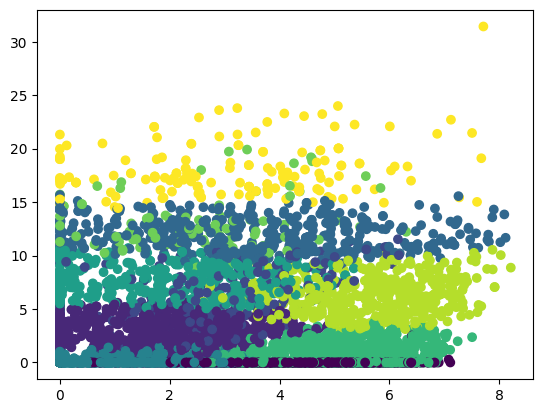

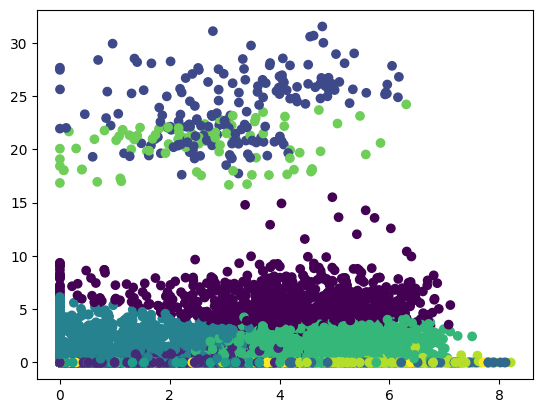

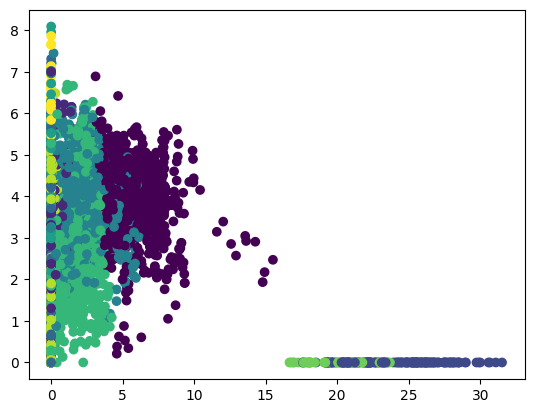

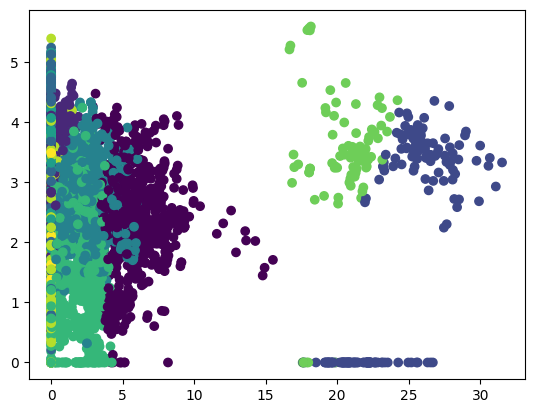

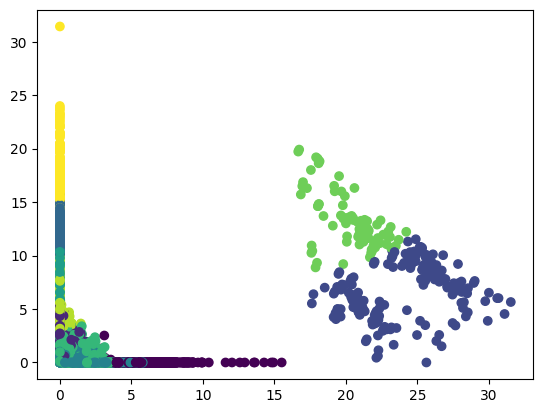

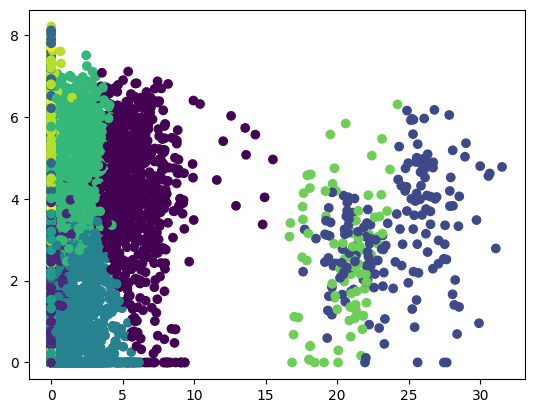

In [14]:
# Use KMeans clustering to cluster the encoded features
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(encoded_features_train)

# Visualize the clusters in the validation set
encoded_features_val_clusters = kmeans.predict(encoded_features_val)

for i in range(0,5):
    for j in range(0,5):
        if i != j:
            plt.scatter(encoded_features_val[:, i], encoded_features_val[:, j], c=encoded_features_val_clusters)
            plt.show()